In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Required Library

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of images in the train set :  4083
Number of images in the test set ;  511
Number of images in prediction set :  6


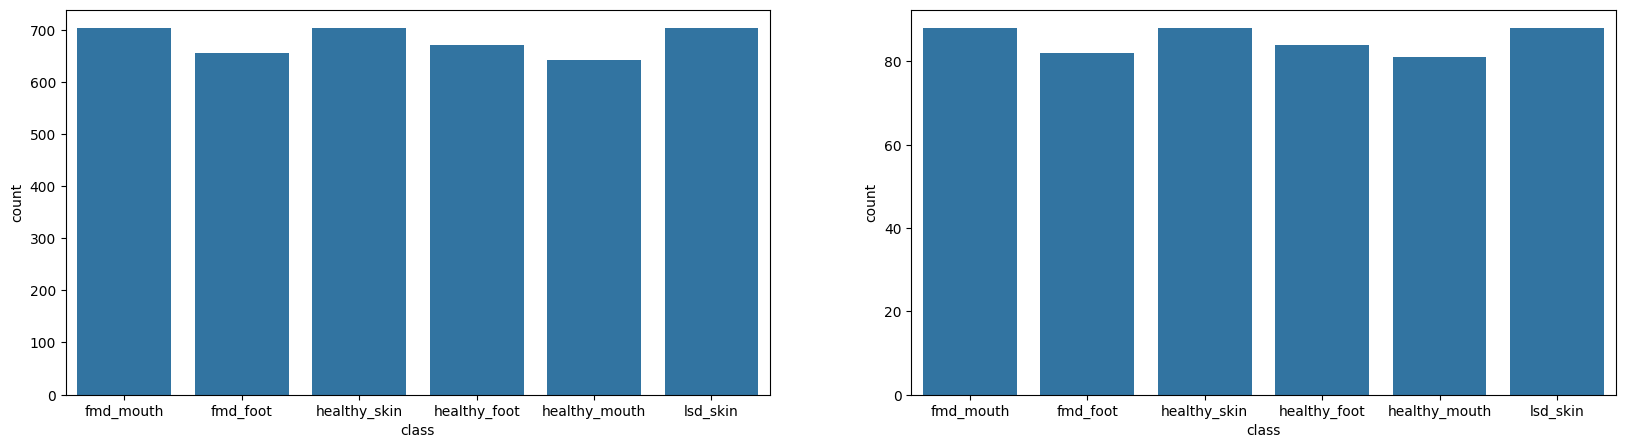

In [3]:
root_path = '/content/drive/MyDrive/Capstone/finalized_data'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/drive/MyDrive/Capstone/Dataset/train/' #one more seg_train folder within
seg_test_folders = '/content/drive/MyDrive/Capstone/Dataset/test/'
seg_pred_folders = '/content/drive/MyDrive/Capstone/Dataset/val/'
quantity_tr = {}
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [4]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    # save to json:
    hist_json_file = model_name+'_history.json'
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']


    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [5]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 4083 images belonging to 6 classes.
Found 511 images belonging to 6 classes.


In [6]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'fmd_foot': 0, 'fmd_mouth': 1, 'healthy_foot': 2, 'healthy_mouth': 3, 'healthy_skin': 4, 'lsd_skin': 5}
{0: 'fmd_foot', 1: 'fmd_mouth', 2: 'healthy_foot', 3: 'healthy_mouth', 4: 'healthy_skin', 5: 'lsd_skin'}


In [7]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

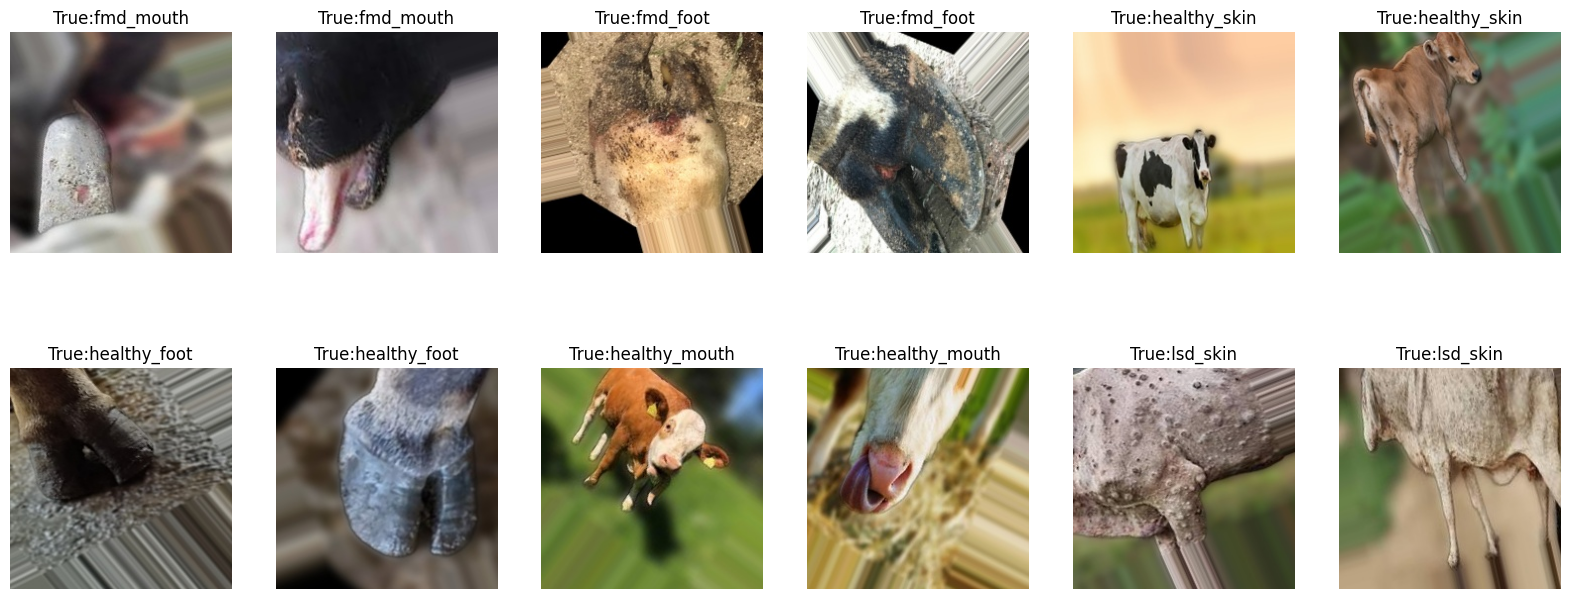

In [ ]:
show_few_images(2)


In [8]:
tf.keras.backend.clear_session()

# epoch config
#benchmark_epoch = 60
vgg_epoch = 80
resnet_epoch = 100
inception_epoch = 80

In [9]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(6,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 67, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

# VGG16

In [ ]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16

number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)


# Plot training & validation accuracy values
plt.plot(vgg16_history.history['acc'])
plt.plot(vgg16_history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/80
128/128 [==============================] - ETA: 0s - loss: 1.1923 - acc: 0.5626
Epoch 1: val_acc improved from -inf to 0.70059, saving model to vgg_16_-saved-model-01-acc-0.70.hdf5
128/128 [==============================] - 1262s 10s/step - loss: 1.1923 - acc: 0.5626 - val_loss: 0.8461 - val_acc: 0.7006


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/80
128/128 [==============================] - ETA: 0s - loss: 0.7935 - acc: 0.7103
Epoch 2: val_acc improved from 0.70059 to 0.75734, saving model to vgg_16_-saved-model-02-acc-0.76.hdf5
128/128 [==============================] - 1228s 10s/step - loss: 0.7935 - acc: 0.7103 - val_loss: 0.6743 - val_acc: 0.7573
Epoch 3/80
128/128 [==============================] - ETA: 0s - loss: 0.6691 - acc: 0.7573
Epoch 3: val_acc improved from 0.75734 to 0.78474, saving model to vgg_16_-saved-model-03-acc-0.78.hdf5
128/128 [==============================] - 1226s 10s/step - loss: 0.6691 - acc: 0.7573 - val_loss: 0.5857 - val_acc: 0.7847
Epoch 4/80
128/128 [==============================] - ETA: 0s - loss: 0.5950 - acc: 0.7810
Epoch 4: val_acc did not improve from 0.78474
128/128 [==============================] - 1227s 10s/step - loss: 0.5950 - acc: 0.7810 - val_loss: 0.5375 - val_acc: 0.7808
Epoch 5/80
 29/128 [=====>........................] - ETA: 13:59 - loss: 0.5437 - acc: 0.7942

# ResNet-50

94765736/94765736 [==============================] - 0s 0us/step


Epoch 1/100
128/128 [==============================] - ETA: 0s - loss: 1.1446 - acc: 0.6980
Epoch 1: val_acc improved from -inf to 0.17221, saving model to resnet50-saved-model-01-val_acc-0.17.hdf5
128/128 [==============================] - 78s 426ms/step - loss: 1.1446 - acc: 0.6980 - val_loss: 2.9193 - val_acc: 0.1722 - lr: 0.0100
Epoch 2/100
128/128 [==============================] - ETA: 0s - loss: 0.1984 - acc: 0.9351
Epoch 2: val_acc did not improve from 0.17221
128/128 [==============================] - 49s 383ms/step - loss: 0.1984 - acc: 0.9351 - val_loss: 2.6689 - val_acc: 0.1546 - lr: 0.0100
Epoch 3/100
128/128 [==============================] - ETA: 0s - loss: 0.0919 - acc: 0.9711
Epoch 3: val_acc improved from 0.17221 to 0.17417, saving model to resnet50-saved-model-03-val_acc-0.17.hdf5
128/128 [==============================] - 49s 386ms/step - loss: 0.0919 - acc: 0.9711 - val_loss: 2.9157 - val_acc: 0.1742 - lr: 0.0100
Epoch 4/100
128/128 [==============================]

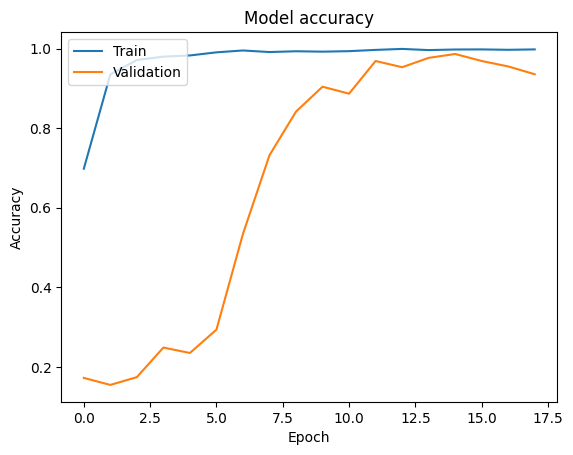

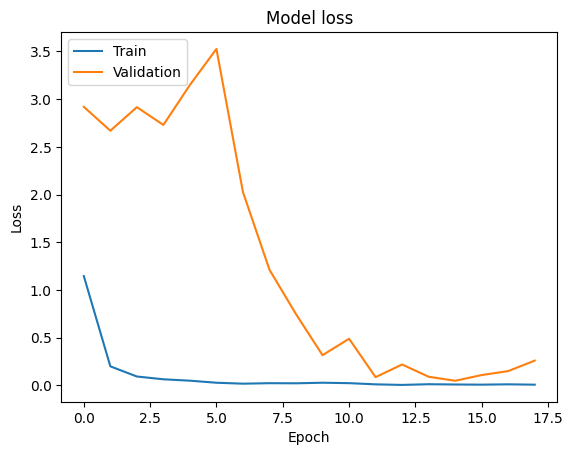

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=6)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(6,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

#do_history_stuff(resnet50_history, 'resnet50_model')


# def plot_loss_from_history(history):
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(loss))

#     sns.lineplot(x=epochs, y=loss, label='Training Loss')
#     sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
#     plt.title('Training and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

# # Call the function with the corrected arguments
# plot_loss_from_history(resnet50_history)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(resnet50_history.history['acc'])
plt.plot(resnet50_history.history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(resnet50_history.history['loss'])
plt.plot(resnet50_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()







# InceptionV3_model

87910968/87910968 [==============================] - 0s 0us/step


Epoch 1/80
128/128 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.7494

128/128 [==============================] - 61s 393ms/step - loss: 0.9416 - accuracy: 0.7494 - val_loss: 0.5945 - val_accuracy: 0.8767
Epoch 2/80
128/128 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.9118

128/128 [==============================] - 45s 354ms/step - loss: 0.2739 - accuracy: 0.9118 - val_loss: 0.2551 - val_accuracy: 0.9159
Epoch 3/80
128/128 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9505

128/128 [==============================] - 46s 356ms/step - loss: 0.1566 - accuracy: 0.9505 - val_loss: 0.3950 - val_accuracy: 0.9022
Epoch 4/80
128/128 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9615

128/128 [==============================] - 46s 357ms/step - loss: 0.1221 - accuracy: 0.9615 - val_loss: 0.2066 - val_accuracy: 0.9472
Epoch 5/80
128/128 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9743

128/128 [==============================] - 45s 355ms/step - loss: 0.0849 - accuracy: 0.9743 - val_loss: 0.2699 - val_accuracy: 0.9413
Epoch 6/80
128/128 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9787

128/128 [==============================] - 46s 358ms/step - loss: 0.0714 - accuracy: 0.9787 - val_loss: 0.1530 - val_accuracy: 0.9609
Epoch 7/80
128/128 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9831

128/128 [==============================] - 46s 357ms/step - loss: 0.0707 - accuracy: 0.9831 - val_loss: 0.1426 - val_accuracy: 0.9609
Epoch 8/80
128/128 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9838

128/128 [==============================] - 47s 364ms/step - loss: 0.0623 - accuracy: 0.9838 - val_loss: 0.1479 - val_accuracy: 0.9667
Epoch 9/80
128/128 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9853

128/128 [==============================] - 46s 360ms/step - loss: 0.0613 - accuracy: 0.9853 - val_loss: 0.0983 - val_accuracy: 0.9746
Epoch 10/80
128/128 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9885

128/128 [==============================] - 46s 360ms/step - loss: 0.0470 - accuracy: 0.9885 - val_loss: 0.1203 - val_accuracy: 0.9687
Epoch 11/80
128/128 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9902

128/128 [==============================] - 50s 390ms/step - loss: 0.0352 - accuracy: 0.9902 - val_loss: 0.1418 - val_accuracy: 0.9746
Epoch 12/80
128/128 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9917

128/128 [==============================] - 46s 363ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.1281 - val_accuracy: 0.9765
Epoch 13/80
128/128 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9927

128/128 [==============================] - 47s 366ms/step - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.1627 - val_accuracy: 0.9726
Epoch 14/80
128/128 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9934

128/128 [==============================] - 46s 363ms/step - loss: 0.0229 - accuracy: 0.9934 - val_loss: 0.1294 - val_accuracy: 0.9746
Epoch 15/80
128/128 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9917

128/128 [==============================] - 50s 391ms/step - loss: 0.0332 - accuracy: 0.9917 - val_loss: 0.1177 - val_accuracy: 0.9726
Epoch 16/80
128/128 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9944

128/128 [==============================] - 47s 368ms/step - loss: 0.0196 - accuracy: 0.9944 - val_loss: 0.1435 - val_accuracy: 0.9726
Epoch 17/80
128/128 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9961

128/128 [==============================] - 54s 424ms/step - loss: 0.0104 - accuracy: 0.9961 - val_loss: 0.1544 - val_accuracy: 0.9648
Epoch 18/80
128/128 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9968

128/128 [==============================] - 47s 366ms/step - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.1401 - val_accuracy: 0.9765
Epoch 19/80
128/128 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9941

128/128 [==============================] - 46s 359ms/step - loss: 0.0189 - accuracy: 0.9941 - val_loss: 0.3258 - val_accuracy: 0.9550
Epoch 20/80
128/128 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9934

128/128 [==============================] - 48s 372ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.1618 - val_accuracy: 0.9706
Epoch 21/80
128/128 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9968

128/128 [==============================] - 45s 353ms/step - loss: 0.0201 - accuracy: 0.9968 - val_loss: 0.1862 - val_accuracy: 0.9687
Epoch 22/80
128/128 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9956

128/128 [==============================] - 46s 356ms/step - loss: 0.0199 - accuracy: 0.9956 - val_loss: 0.1316 - val_accuracy: 0.9706
Epoch 23/80
128/128 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9953

128/128 [==============================] - 45s 350ms/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.1422 - val_accuracy: 0.9765


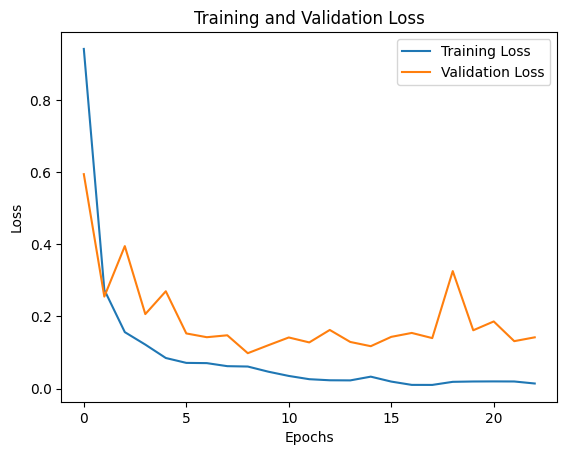

In [ ]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

#do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)

def plot_loss_from_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    sns.lineplot(x=epochs, y=loss, label='Training Loss')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function with the corrected arguments
plot_loss_from_history(inceptionv3_history)




In [ ]:
vgg_best_model = vgg16_final_model
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model

In [ ]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):

    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:

        path = os.path.join(seg_test_folders,folder,image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)

        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)

        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)

        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])
        #image_prediction = mode([vgg16_image_prediction, inception_image_prediction])
        #image_prediction = mode([resnet_50_image_prediction, inception_image_prediction])
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 18ms/step


In [ ]:
#Confusion Matrix For VGG16

from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):

    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)

    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.8140900195694716
               precision    recall  f1-score   support

     fmd_foot       0.75      0.93      0.83        82
    fmd_mouth       0.85      0.69      0.76        88
 healthy_foot       0.94      0.76      0.84        84
healthy_mouth       0.80      0.91      0.86        81
 healthy_skin       0.80      0.80      0.80        88
     lsd_skin       0.80      0.81      0.80        88

     accuracy                           0.81       511
    macro avg       0.82      0.82      0.81       511
 weighted avg       0.82      0.81      0.81       511



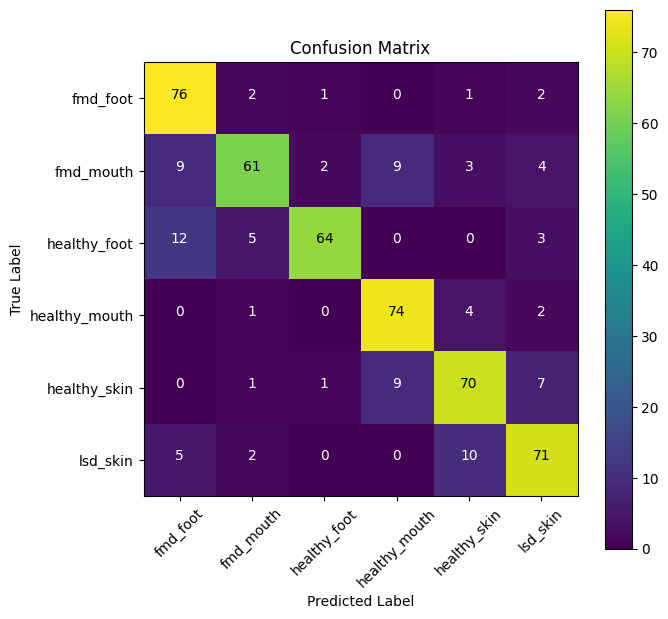

In [ ]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.6908023483365949
               precision    recall  f1-score   support

     fmd_foot       0.81      0.56      0.66        82
    fmd_mouth       0.58      0.83      0.69        88
 healthy_foot       0.69      0.35      0.46        84
healthy_mouth       0.86      0.70      0.78        81
 healthy_skin       0.85      0.81      0.83        88
     lsd_skin       0.56      0.88      0.68        88

     accuracy                           0.69       511
    macro avg       0.73      0.69      0.68       511
 weighted avg       0.72      0.69      0.68       511



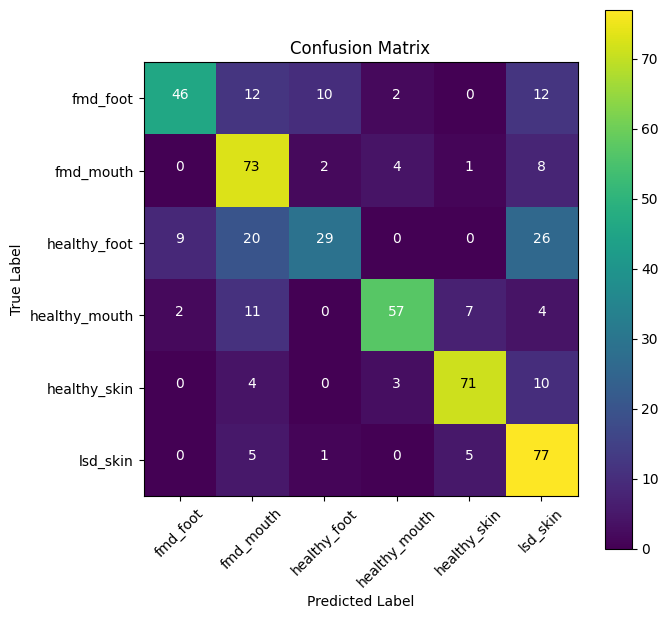

In [ ]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.8962818003913894
               precision    recall  f1-score   support

     fmd_foot       0.87      0.95      0.91        82
    fmd_mouth       0.92      0.92      0.92        88
 healthy_foot       0.87      0.90      0.89        84
healthy_mouth       0.96      0.89      0.92        81
 healthy_skin       0.90      0.90      0.90        88
     lsd_skin       0.87      0.82      0.84        88

     accuracy                           0.90       511
    macro avg       0.90      0.90      0.90       511
 weighted avg       0.90      0.90      0.90       511



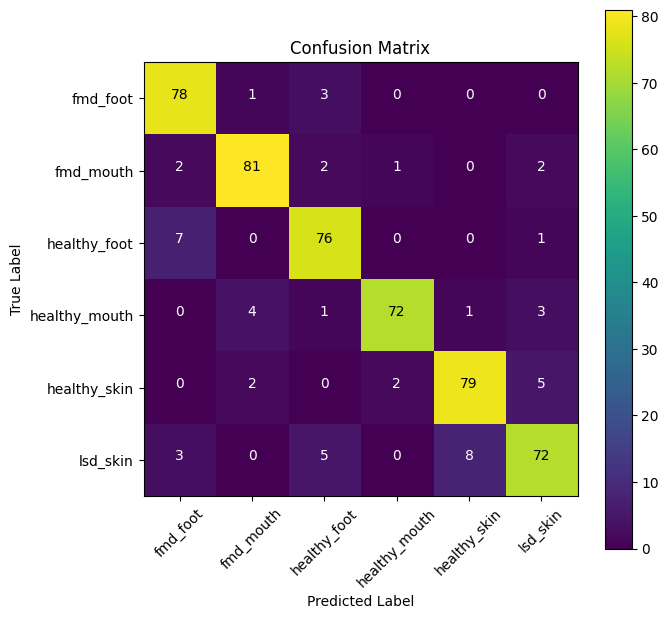

In [ ]:
# Inception model classification report
clf_report(true_value, inception_pred)

In [ ]:
true_value = []
combined_model_pred = []

for folder in os.listdir(seg_test_folders):
    test_image_ids = os.listdir(os.path.join(seg_test_folders, folder))

    for image_id in test_image_ids[:int(len(test_image_ids))]:
        path = os.path.join(seg_test_folders, folder, image_id)

        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path), (150, 150))
        img_normalized = img / 255

        # VGG
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))

        # ResNet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))

        # Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))

        # Combine Predictions (Majority Vote)
        combined_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])[0]
        #combined_prediction = mode([vgg16_image_prediction, inception_image_prediction])[0]
        combined_model_pred.append(combined_prediction)


1/1 [==============================] - 0s 25ms/step


In [ ]:
combined_accuracy = np.sum(np.array(true_value) == np.array(combined_model_pred)) / len(true_value)
print('Combined Model Accuracy:', combined_accuracy)


Combined Model Accuracy: 0.8962818003913894


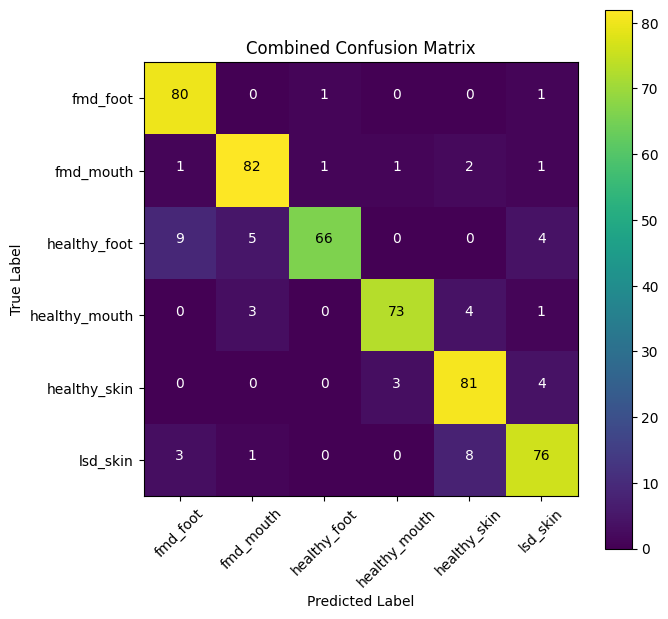

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_combined_confusion_matrix(true_value, model_pred):
    classes = validation_generator.class_indices.keys()

    plt.figure(figsize=(7, 7))
    cm = confusion_matrix(true_value, model_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
    plt.title('Combined Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() * 0.8
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Call the function with true labels and combined predictions
plot_combined_confusion_matrix(true_value, combined_model_pred)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming true_value and combined_model_pred are your true labels and predicted labels
# Generate the classification report
report = classification_report(true_value, combined_model_pred)

# Print the classification report
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_value, combined_model_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#combine vgg16,inceptionv3


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.91        82
           1       0.90      0.93      0.92        88
           2       0.97      0.79      0.87        84
           3       0.95      0.90      0.92        81
           4       0.85      0.92      0.89        88
           5       0.87      0.86      0.87        88

    accuracy                           0.90       511
   macro avg       0.90      0.90      0.90       511
weighted avg       0.90      0.90      0.90       511

